# Casava Leaf Disease Classification with ResNet-152

The goal of this project is to assist the Makerere University AI Lab in identifying the type of disease present on the Casava leaf image. 


# The Problem

"As the second-largest provider of carbohydrates in Africa, cassava is a key food security crop grown by smallholder farmers because it can withstand harsh conditions. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but viral diseases are major sources of poor yields. With the help of data science, it may be possible to identify common diseases so they can be treated.

Existing methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. As an added challenge, effective solutions for farmers must perform well under significant constraints, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

In this competition, we introduce a dataset of 21,367 labeled images collected during a regular survey in Uganda. Most images were crowdsourced from farmers taking photos of their gardens, and annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala. This is in a format that most realistically represents what farmers would need to diagnose in real life.

Your task is to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf. With your help, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage."

(https://www.kaggle.com/c/cassava-leaf-disease-classification/overview)

# Importing Necessary Libraries & Packages, Defining Datasets, and Preprocessing

Importing Libraries & Packages.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

Defining the Datasets.

Due to the size of the dataset, I will need to upload it into Google Drive and then begin the mounting process into Colab. Once the mounting process is complete, I will then extract the data into my local environment and unzip the file.

To keep my file system organized, I included -d train to create a new directory called train to house all of the image files. Using > /dev/null surpresses the output which keeps your notebook a little cleaner, however, you can remove it to monitor the unzipping of all of the files. 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip gdrive/My\ Drive/Datasets/train_images.zip -d train > /dev/null

In [5]:
train_csv = '/content/train.csv'
label_json = '/content/label_num_to_disease_map.json'
images_directory = '/content/train'

In [6]:
train_csv = pd.read_csv(train_csv)
train_csv['label'] = train_csv['label'].astype('string')

label_class = pd.read_json(label_json, orient = 'index')
label_class = label_class.values.flatten().tolist()

In [8]:
print('Label Names: ')
for i, label in enumerate(label_class):
  print(f" {i}. {label}")

Label Names: 
 0. Cassava Bacterial Blight (CBB)
 1. Cassava Brown Streak Disease (CBSD)
 2. Cassava Green Mottle (CGM)
 3. Cassava Mosaic Disease (CMD)
 4. Healthy


In [9]:
train_csv.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


Preprocessing using Keras.

In [10]:
train_gen = ImageDataGenerator(
                                rotation_range = 360,
                                width_shift_range = 0.1,
                                height_shift_range = 0.1,
                                brightness_range = [0.1, 0.9],
                                shear_range = 25,
                                zoom_range = 0.3,
                                channel_shift_range = 0.1,
                                horizontal_flip = True,
                                vertical_flip = True,
                                rescale = 1/255,
                                validation_split = 0.15
)

valid_gen = ImageDataGenerator(
                                rescale = 1/255,
                                validation_split = 0.15
)

In [11]:
BATCH_SIZE = 16
IMG_SIZE = 224

In [12]:
train_generator = train_gen.flow_from_dataframe(
                                                dataframe = train_csv,
                                                directory = images_directory,
                                                x_col = 'image_id',
                                                y_col = 'label',
                                                target_size = (IMG_SIZE, IMG_SIZE),
                                                class_mode = 'categorical',
                                                batch_size = BATCH_SIZE,
                                                shuffle = True,
                                                subset = 'training'
)

valid_generator = valid_gen.flow_from_dataframe(
                                                dataframe = train_csv,
                                                directory = images_directory,
                                                x_col = 'image_id',
                                                y_col = 'label',
                                                target_size = (IMG_SIZE, IMG_SIZE),
                                                class_mode = 'categorical',
                                                batch_size = BATCH_SIZE,
                                                shuffle = False,
                                                subset = 'validation'
)

Found 18188 validated image filenames belonging to 5 classes.
Found 3209 validated image filenames belonging to 5 classes.


In [13]:
batch = next(train_generator)
images = batch[0]
labels = batch[1]

Plotting the Images

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


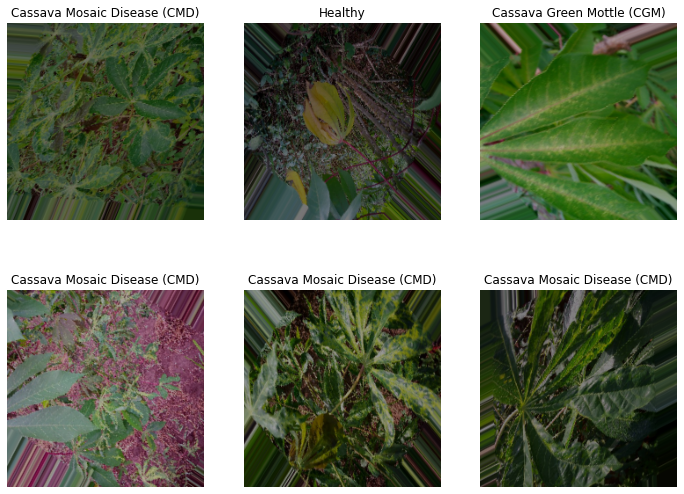

In [14]:
plt.figure(figsize = (12, 9))
for i, (img, label) in enumerate(zip (images, labels)):
  plt.subplot(2, 3, i%6 + 1)
  plt.axis('off')
  plt.imshow(img)
  plt.title(label_class[np.argmax(label)])

  if i == 15:
    break

# Building the Model

ResNet-152
(https://www.kaggle.com/pytorch/resnet152)



In [15]:
base = tf.keras.applications.ResNet152(include_top = False, weights = 'imagenet', input_shape = [IMG_SIZE,IMG_SIZE, 3])

234700800/234698864 [==============================] - 2s 0us/step


In [16]:
model = tf.keras.Sequential()
model.add(base)
model.add(BatchNormalization(axis = -1))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))

In [17]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.01), metrics = ['acc'])

In [18]:
# These Three Imports are Called Separetly and with 'tensorflow' instead of 'tf'
# Because TenorFlow Kept Throwing a ModelNotFoundError
# You Cannot Use the Alias to Call Other Modules
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


model_save = tf.keras.callbacks.ModelCheckpoint(
                                                'Model',
                                                save_best_only = True,
                                                save_weights_only = True,
                                                monitor = 'val_loss',
                                                mode = 'min', verbose = 1
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'acc', min_delta = 0.001, patience = 5, mode = 'min', verbose = 1, restore_best_weights = True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, min_delta = 0.001, mode = 'min', verbose = 1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model{epoch:08d}.h5', save_freq = 5 )

# Training the Model

In [ ]:
history = model.fit(
                    train_generator,
                    steps_per_epoch = train_generator.samples // train_generator.batch_size,
                    epochs = 10,
                    validation_data = valid_generator,
                    validation_steps = valid_generator.samples // valid_generator.batch_size,
                    batch_size = BATCH_SIZE,
                    callbacks = [checkpoint]
)

In [21]:
model.save('model.h5')

# Evaluation Metrics

Loading the Model

In [22]:
loaded_model = tf.keras.models.load_model('/content/model.h5')

Confusion Matrix

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = loaded_model.predict(valid_generator, valid_generator.samples // valid_generator.batch_size + 5)
y_pred = np.argmax(Y_pred, axis = 1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, y_pred))

Confusion Matrix
[[   0    7    0  141    0]
 [   4   12    3  307    0]
 [   2   11    2  350    0]
 [   9   52    1 1922    0]
 [   5   13    1  367    0]]


Classification Report

In [25]:
target_names = list(train_generator.class_indices.keys())
print(classification_report(valid_generator.classes, y_pred, target_names = target_names))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       148
           1       0.13      0.04      0.06       326
           2       0.29      0.01      0.01       365
           3       0.62      0.97      0.76      1984
           4       0.00      0.00      0.00       386

    accuracy                           0.60      3209
   macro avg       0.21      0.20      0.17      3209
weighted avg       0.43      0.60      0.48      3209



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


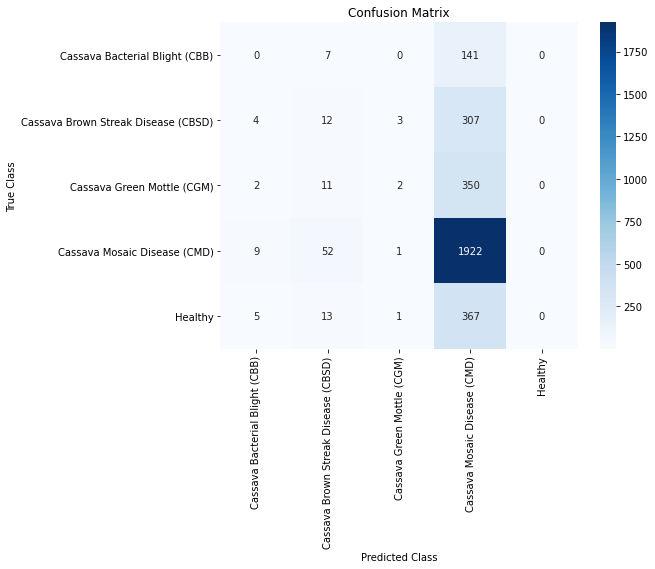

In [26]:
import seaborn as sns

cm = confusion_matrix(valid_generator.classes, y_pred)
labels = ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)','Healthy']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

Loading Test Images & Predictions

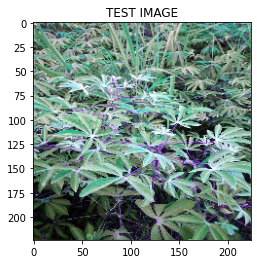

In [29]:
test_img = '/content/test_images/2216849948.jpg'

img = cv2.imread(test_img)
resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)).reshape(-1, IMG_SIZE, IMG_SIZE, 3)/255

plt.figure(figsize=(8,4))
plt.title('TEST IMAGE')
plt.imshow(resized_img[0])

In [32]:
preds = []
sample_submission = pd.read_csv('/content/sample_submission.csv')

for image in sample_submission.image_id:
    img = tf.keras.preprocessing.image.load_img(test_img)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.reshape(img, (-1, IMG_SIZE, IMG_SIZE, 3))
    prediction = loaded_model.predict(img/255)
    preds.append(np.argmax(prediction))

my_submission = pd.DataFrame({'image_id': sample_submission.image_id, 'label': preds})
my_submission.to_csv('submission.csv', index=False) 

In [33]:
print('Submission File: ')
print(my_submission.head())

Submission File: 
         image_id  label
0  2216849948.jpg      3
